In [19]:
import os
import shutil
from collections import Counter
import math
from tqdm import tqdm

In [2]:
data_dir = '../data/ImageNet Dogs'
label_file = 'labels.csv'
train_dir = 'train'
test_dir = 'test'
input_dir = 'train_valid_test'
valid_ratio = 0.1

# **处理数据集**

In [ ]:
def handle_data(data_dir, lable_file, train_dir, test_dir, input_dir, valid_ratio):
    
    with open(os.path.join(data_dir, label_file), 'r') as f:   
        lines = f.readlines()[1:]   # 跳过文件第一栏
        # 去掉了每行末尾的换行符，并且将每行以逗号分隔为列表，最终得到一个二维列表，其中每个子列表代表文件中的一行数据，每个子列表中的元素是该行数据以逗号分隔后的各个部分
        tokens = [l.rstrip().split(',') for l in lines] 
        idx_label = dict((idx, label) for idx, label in tokens)
    labels = set(idx_label.values())  # 转换成集合，包含了所有不重复的标签
    
    num_train = len(os.listdir(os.path.join(data_dir, train_dir)))  # listdir 获取所有图片名称，最终获取训练集数量
    # 训练集中数量最少一类的数量(验证集中要每类标签样本数目一致，取样本最少的一类，以防标签不够)
    min_num_train_sample = (Counter(idx_label.values()).most_common()[:-2:-1][0][1])  # 训练集中样本数最少的标签对应的样本数
    # 验证集中每类狗的数量
    num_valid_sample = math.floor(min_num_train_sample * valid_ratio)   # math.floor 向下取整
    label_count = dict()
    
    def mkdir_if_not_exist(path):  # 判断是否有存放拆分后的数据集的文件夹，没有就重新创建
        if not os.path.exists(os.path.join(*path)):
            os.makedirs(os.path.join(*path))
            
    # 整理训练和验证集，将数据集进行拆分复制到预先设置好的存放文件夹中
    for train_file in tqdm(os.listdir(os.path.join(data_dir, train_dir))):
        idx = train_file.split('.')[0]
        label = idx_label[idx]
        mkdir_if_not_exist([data_dir, input_dir, 'train_valid', label])
        shutil.copy(os.path.join(data_dir, train_dir, train_file), 
                    os.path.join(data_dir, input_dir, 'train_valid', label))  # 复制文件
        
        if label not in label_count or label_count[label] < num_valid_sample:
            mkdir_if_not_exist([data_dir, input_dir, 'valid', label])
            shutil.copy(os.path.join(data_dir, train_dir, train_file),
                        os.path.join(data_dir, input_dir, 'valid', label))
            label_count[label] = label_count.get(label, 0) + 1  # 更新标签计数字典，增加该标签的计数值
        else:
            mkdir_if_not_exist([data_dir, input_dir, 'train', label])
            shutil.copy(os.path.join(data_dir, train_dir, train_file),
                        os.path.joint(data_dir, input_dir, 'train', label))
            
    # 整理测试集， 将测试集复制存放在新路径下的 unknow 文件夹中
    mkdir_if_not_exist([data_dir, input_dir, 'test', 'unknown'])
    for test_file in tqdm(os.listdir(os.path.join(data_dir, test_dir))):
        shutil.copy(os.path.join(data_dir, test_dir, test_file),
                    os.path.join(data_dir, input_dir, 'test', 'unknown'))

调用上述函数即可实现数据集分类

# **加载数据集**

In [39]:
import os
import cv2
import numpy as np
import torchvision.transforms as transforms
from PIL import Image
from torchvision import datasets
from torch.utils.data import DataLoader

In [30]:
data_transform = transforms.Compose([
    transforms.Resize(223),
    transforms.CenterCrop(223),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.490, 0.482, 0.445], std=[0.240, 0.237, 0.257])
])

In [31]:
new_data_dir = '../data/ImageNet Dogs/train_valid_test'
train_dataset = datasets.ImageFolder(root = os.path.join(new_data_dir, 'train'), transform=data_transform)
valid_dataset = datasets.ImageFolder(root = os.path.join(new_data_dir, 'valid'), transform=data_transform)

In [37]:
img, label = valid_dataset[11]
img.shape, label

(torch.Size([3, 223, 223]), 1)

In [41]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


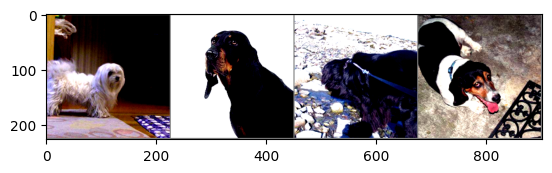

tensor(73) tensor(12) tensor(78) tensor(8)


In [45]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
dataiter = iter(train_loader)
imgs, labels = dataiter.next()
imshow(torchvision.utils.make_grid(imgs))
print(labels[0], labels[1], labels[2], labels[3])